# NMF Recommender System for MovieLens
Description: This program implements a **movie recommendation system** based on **Non-Negative Matrix Factorization (NMF)** using the **MovieLens** dataset. It covers several sections as detailed below:
1. Data Loading and Preprocessing
* Data loading: The program starts by loading the MovieLens dataset, which includes two main files— movies.csv (containing movie information) and ratings.csv (containing user ratings for movies).
* Preprocessing: The program checks for missing values in the ratings dataset and provides a statistical overview of the data.
2. Statistical Analysis
*  Correlation Analysis: The program performs a correlation analysis between user activity (number of ratings given) and the average rating given by users. It visualizes this correlation using a scatter plot and calculates the correlation coefficient.
3. Model Training and Evaluation
* Data Splitting: The ratings data is split into training and test sets using an 80-20 split.
* User-Item Matrix Creation: A user-item matrix is created from the training data, where rows represent movies, columns represent users, and the values represent ratings. Missing values are filled with zeros.
* NMF Application: Non-Negative Matrix Factorization (NMF) is applied to the user-item matrix to decompose it into two matrices, W (movie features) and H (user features), which are used to predict user ratings.
* RMSE Calculation and Visualization: The program evaluates the NMF model by calculating the Root Mean Squared Error (RMSE) on the test set. The RMSE measures the difference between the predicted and actual ratings. It is visualized using a bar plot to provide a clear representation of the model's performance.
4. Additional Visualization
* Rating Distributions: The program calculates the predicted rating for each sample in the test set and draws a histogram of the distribution of true ratings and predicted ratings.
5. Recommendation Functions and Examples
* Movie List Recommendation: Recommends the top top_n movies with the highest scores for a user based on the user ID and the matrices W and H obtained from NMF decomposition.
* Similar Movie Search: Finds the top top_n movies most similar to a specified movie using cosine similarity based on the movie ID and matrix W.
* Specific Movie Recommendation: Recommends a movie with the highest score for a user based on the user ID and matrices W and H.
* Example Calls: The program calls the above recommendation functions to recommend a movie list for user 1, find movies similar to the movie with ID 1, and recommend a specific movie for user 1, and print the recommendation results.






In [1]:
from google.colab import files
uploaded = files.upload()

Saving movies.csv to movies.csv
Saving ratings.csv to ratings.csv


In [39]:
import numpy as np
import pandas as pd
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load MovieLens dataset
ratings_path = "ratings.csv"
movies_path = "movies.csv"

ratings = pd.read_csv(ratings_path)
movies = pd.read_csv(movies_path)

In [40]:
# Preprocessing: Check for missing values
print("Missing values in ratings:")
print(ratings.isnull().sum())

Missing values in ratings:
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


In [41]:
# Database description
print("Dataset Overview:")
print(ratings.describe())
print(movies.describe())

Dataset Overview:
              userId        movieId         rating     timestamp
count  100836.000000  100836.000000  100836.000000  1.008360e+05
mean      326.127564   19435.295718       3.501557  1.205946e+09
std       182.618491   35530.987199       1.042529  2.162610e+08
min         1.000000       1.000000       0.500000  8.281246e+08
25%       177.000000    1199.000000       3.000000  1.019124e+09
50%       325.000000    2991.000000       3.500000  1.186087e+09
75%       477.000000    8122.000000       4.000000  1.435994e+09
max       610.000000  193609.000000       5.000000  1.537799e+09
             movieId
count    9742.000000
mean    42200.353623
std     52160.494854
min         1.000000
25%      3248.250000
50%      7300.000000
75%     76232.000000
max    193609.000000


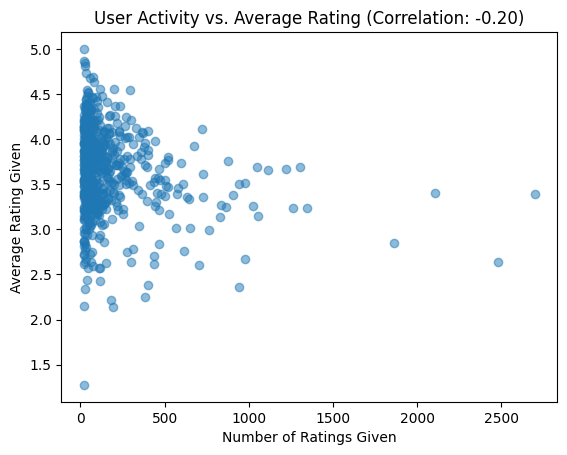

Correlation between user activity and average rating: -0.20


In [42]:
# Statistical analysis: Correlation between user activity and ratings
def user_activity_analysis(ratings):
    user_activity = ratings.groupby('userId')['rating'].count()
    avg_rating = ratings.groupby('userId')['rating'].mean()
    correlation, _ = pearsonr(user_activity, avg_rating)

    plt.scatter(user_activity, avg_rating, alpha=0.5)
    plt.xlabel("Number of Ratings Given")
    plt.ylabel("Average Rating Given")
    plt.title(f"User Activity vs. Average Rating (Correlation: {correlation:.2f})")
    plt.show()

    return correlation

# Example: Perform user activity analysis
correlation = user_activity_analysis(ratings)
print(f"Correlation between user activity and average rating: {correlation:.2f}")

In [43]:
# Split data into training and test sets
train_ratings, test_ratings = train_test_split(ratings, test_size=0.2, random_state=42)

# Create user-item matrix for training
train_user_item_matrix = train_ratings.pivot(index='movieId', columns='userId', values='rating').fillna(0)

# Apply NMF for recommendation
nmf = NMF(n_components=20, random_state=42)
W = nmf.fit_transform(train_user_item_matrix)
H = nmf.components_

Root Mean Squared Error (RMSE): 3.0464


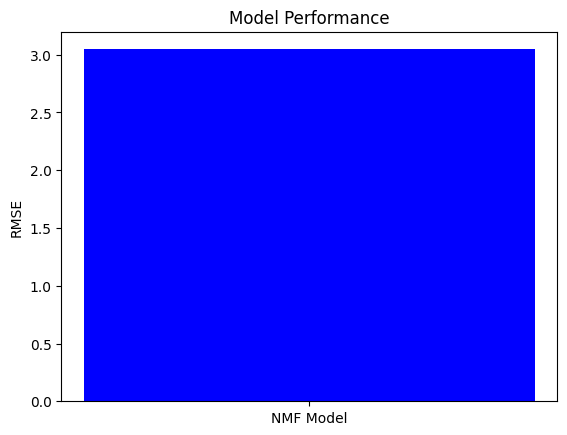

In [44]:
# Evaluate model using RMSE
def compute_rmse(nmf, test_ratings, train_user_item_matrix):
    predictions = []
    actuals = []

    for _, row in test_ratings.iterrows():
        user_id = row['userId']
        movie_id = row['movieId']

        if user_id in train_user_item_matrix.columns and movie_id in train_user_item_matrix.index:
            user_index = train_user_item_matrix.columns.get_loc(user_id)
            movie_index = np.where(train_user_item_matrix.index == movie_id)[0][0]
            prediction = np.dot(W[movie_index], H[:, user_index])
            predictions.append(prediction)
            actuals.append(row['rating'])

    # Calculate RMSE without the 'squared' argument, then take the square root
    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    return rmse

# Call the function and store the result in a variable named rmse
rmse = compute_rmse(nmf, test_ratings, train_user_item_matrix)
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

# Visualization of RMSE
def plot_rmse():
    plt.bar(["NMF Model"], [rmse], color='blue')
    plt.ylabel("RMSE")
    plt.title("Model Performance")
    plt.show()

plot_rmse()

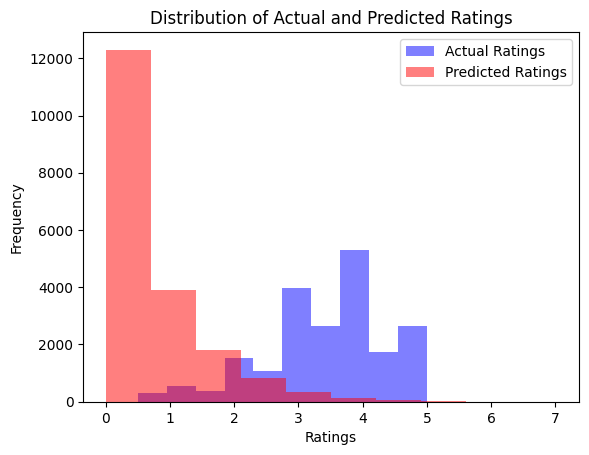

In [45]:
# Plot distribution of true ratings vs predicted ratings
def plot_ratings_distribution(actual_ratings, predicted_ratings):
    plt.hist(actual_ratings, bins=10, alpha=0.5, label="Actual Ratings", color='blue')
    plt.hist(predicted_ratings, bins=10, alpha=0.5, label="Predicted Ratings", color='red')
    plt.xlabel("Ratings")
    plt.ylabel("Frequency")
    plt.title("Distribution of Actual and Predicted Ratings")
    plt.legend()
    plt.show()

# Get actual and predicted ratings for the plot
actual_ratings = test_ratings['rating'].tolist()  # Extract actual ratings from test_ratings
predicted_ratings = [] # Initialize predicted_ratings

for _, row in test_ratings.iterrows():
    user_id = row['userId']
    movie_id = row['movieId']

    if user_id in train_user_item_matrix.columns and movie_id in train_user_item_matrix.index:
        user_index = train_user_item_matrix.columns.get_loc(user_id)
        movie_index = np.where(train_user_item_matrix.index == movie_id)[0][0]
        prediction = np.dot(W[movie_index], H[:, user_index])
        predicted_ratings.append(prediction) # Add prediction to predicted_ratings


plot_ratings_distribution(actual_ratings, predicted_ratings)  # Now call the function with defined variables

In [46]:
# Function to recommend movies for a user
def recommend_movies(user_id, user_item_matrix, W, H, movies, top_n=5):
    if user_id not in user_item_matrix.columns:
        return "User not found."

    user_index = user_item_matrix.columns.get_loc(user_id)
    scores = np.dot(W, H[:, user_index])
    recommendations = pd.DataFrame({'movieId': user_item_matrix.index, 'score': scores})
    recommendations = recommendations.sort_values(by='score', ascending=False).head(top_n)

    return recommendations.merge(movies, on='movieId')[['title', 'score']]

# Example: Get recommendations for user 1
recommendations = recommend_movies(1, train_user_item_matrix, W, H, movies)
target_user = 'User1'
print(f"Recommendations for {target_user}:")
print(recommendations)

Recommendations for User1:
                                               title     score
0          Star Wars: Episode IV - A New Hope (1977)  4.928244
1  Star Wars: Episode V - The Empire Strikes Back...  4.786844
2  Raiders of the Lost Ark (Indiana Jones and the...  4.632853
3  Star Wars: Episode VI - Return of the Jedi (1983)  4.595118
4                  Terminator 2: Judgment Day (1991)  4.385027


In [47]:
# Function to find similar items using cosine similarity
def find_similar_movies(movie_id, W, movies, top_n=5):
    if movie_id not in movies['movieId'].values:
        return "Movie not found."

    movie_index = np.where(train_user_item_matrix.index == movie_id)[0][0]
    similarities = cosine_similarity(W[movie_index].reshape(1, -1), W).flatten()
    similar_indices = similarities.argsort()[::-1][1:top_n+1]
    similar_movie_ids = train_user_item_matrix.index[similar_indices]

    return movies[movies['movieId'].isin(similar_movie_ids)][['title']]

# Example: Find similar movies for a given movie ID
similar_movies = find_similar_movies(1, W, movies)
target_item = 'Movie1'
print(f"Similar movies to {target_item}:")
print(similar_movies)

Similar movies to Movie1:
                                title
32                        Babe (1995)
314               Forrest Gump (1994)
322             Lion King, The (1994)
325                  Mask, The (1994)
510  Silence of the Lambs, The (1991)


In [48]:
# Function to recommend a specific movie based on user preferences
def recommend_specific_movie(user_id, W, H, user_item_matrix, movies):
    if user_id not in user_item_matrix.columns:
        return "User not found."

    user_index = user_item_matrix.columns.get_loc(user_id)
    movie_index = np.argmax(np.dot(W, H[:, user_index]))
    recommended_movie_id = user_item_matrix.index[movie_index]

    return movies[movies['movieId'] == recommended_movie_id][['title']]

# Example: Recommend a specific movie for user 1
specific_movie = recommend_specific_movie(1, W, H, train_user_item_matrix, movies)
target_user = 'User1'
print(f"Recommended movie for {target_user}:")
print(specific_movie)

Recommended movie for User1:
                                         title
224  Star Wars: Episode IV - A New Hope (1977)
